# Importing the necessary libraries

In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau

# Description of the Pneumonia Dataset
The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).
Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients.

# 1. Loading the dataset

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype = object)

In [3]:
train = get_training_data('C:\\Users\\ACER\\Desktop\\Jupyter\\Project v1 (2 Classes) [Complete]\\v1 Dataset\\chest_xray\\train')
test = get_training_data('C:\\Users\\ACER\\Desktop\\Jupyter\\Project v1 (2 Classes) [Complete]\\v1 Dataset\\chest_xray\\test')
val = get_training_data('C:\\Users\\ACER\\Desktop\\Jupyter\\Project v1 (2 Classes) [Complete]\\v1 Dataset\\chest_xray\\val')

# 2. Data Exploration

In [4]:
print(train[268])
train.shape

[array([[ 84,  86,  86, ...,  41,  13,  15],
        [ 89,  91,  88, ...,  56,  15,  14],
        [ 90,  91,  94, ...,  51,  32,   9],
        ...,
        [123, 135, 126, ...,  37,  42,  49],
        [120, 133, 127, ...,  37,  39,  52],
        [122, 130, 127, ...,  37,  39,  51]], dtype=uint8) 0]


(5216, 2)

In [5]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
print(l)      

['Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia'

<Axes: ylabel='count'>

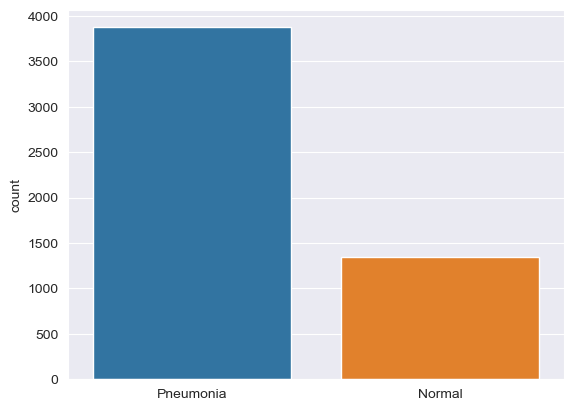

In [6]:
sns.set_style('darkgrid')
sns.countplot(x=l)

**The data seems imbalanced . To increase the no. of training examples, we will use data augmentation**

Text(0.5, 1.0, 'NORMAL')

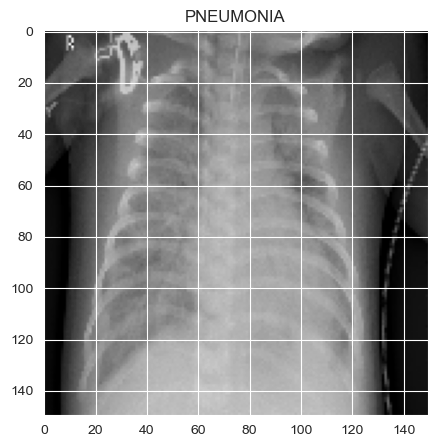

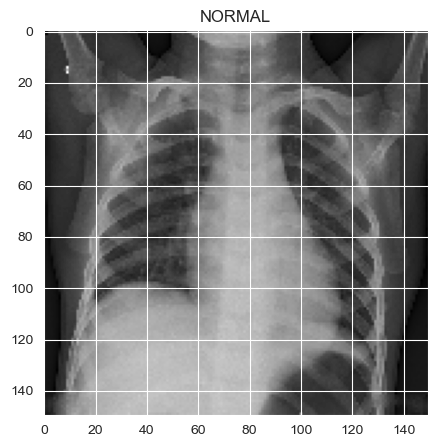

In [7]:
# Previewing the images of both the classes

plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [8]:
# Seperating Labels and Images

x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [9]:
# Accessing the no. of elements of each class in train, test, and val

from collections import Counter

def get_element_frequency(arr):
    frequency_counter = Counter(arr)
    return frequency_counter

for i in (y_train,y_test,y_val):
    print(i)
    frequency = get_element_frequency(i)
    for element, count in frequency.items():
        print(f"The element {element} appears {count} times.")
    print()

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [10]:
num_test_samples = len(x_train)
print("Number of x_train samples:", num_test_samples)

num_test_samples = len(x_test)
print("Number of x_test samples:", num_test_samples)

num_test_samples = len(x_val)
print("Number of x_val samples:", num_test_samples)

Number of x_train samples: 5216
Number of x_test samples: 624
Number of x_val samples: 16


# 3. Data Preprocessing

**Normalization:** We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].

In [11]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [12]:
# Resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

**Data Augmentation:** In order to avoid overfitting problem, we need to expand artificially our dataset. We can make the existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations.
Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.
By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [13]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

For the data augmentation, we did :
1. Randomly rotate some training images by 30 degrees 
2. Randomly Zoom by 20% some training images
3. Randomly shift images horizontally by 10% of the width 
4. Randomly shift images vertically by 10% of the height 
5. Randomly flip images horizontally.
Once our model is ready, we fit the training dataset.

# 4. Model Training

In [14]:
# Building the model

model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

In [15]:
len(model.layers)

22

In [16]:
# Model Architecture Visualization

from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [17]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [18]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 20 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/20
163/163 [==============================] - 353s 2s/step - loss: 0.5439 - accuracy: 0.8493 - val_loss: 37.7159 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
163/163 [==============================] - 322s 2s/step - loss: 0.2525 - accuracy: 0.9024 - val_loss: 37.5455 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/20
163/163 [==============================] - 331s 2s/step - loss: 0.2193 - accuracy: 0.9195 - val_loss: 1.4475 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 4/20
163/163 [==============================] - 321s 2s/step - loss: 0.1980 - accuracy: 0.9289 - val_loss: 2.6521 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/20
163/163 [==============================] - ETA: 0s - loss: 0.1668 - accuracy: 0.9400
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 323s 2s/step - loss: 0.1668 - accuracy: 0.9400 - val_loss: 1.7580 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 6/20
163/163 [==============================] - 321

In [19]:
#from tensorflow.keras.models import load_model

#model = load_model('/kaggle/input/kv1-model.h5')

In [24]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 3s 148ms/step - loss: 0.2924 - accuracy: 0.9199
Loss of the model is -  0.29239895939826965
20/20 [==============================] - 3s 146ms/step - loss: 0.2924 - accuracy: 0.9199
Accuracy of the model is -  91.98718070983887 %


In [25]:
# model.save("Jv1 [91.98% acc] 20 epoch.h5")

# 5. Post-Training Analysis:

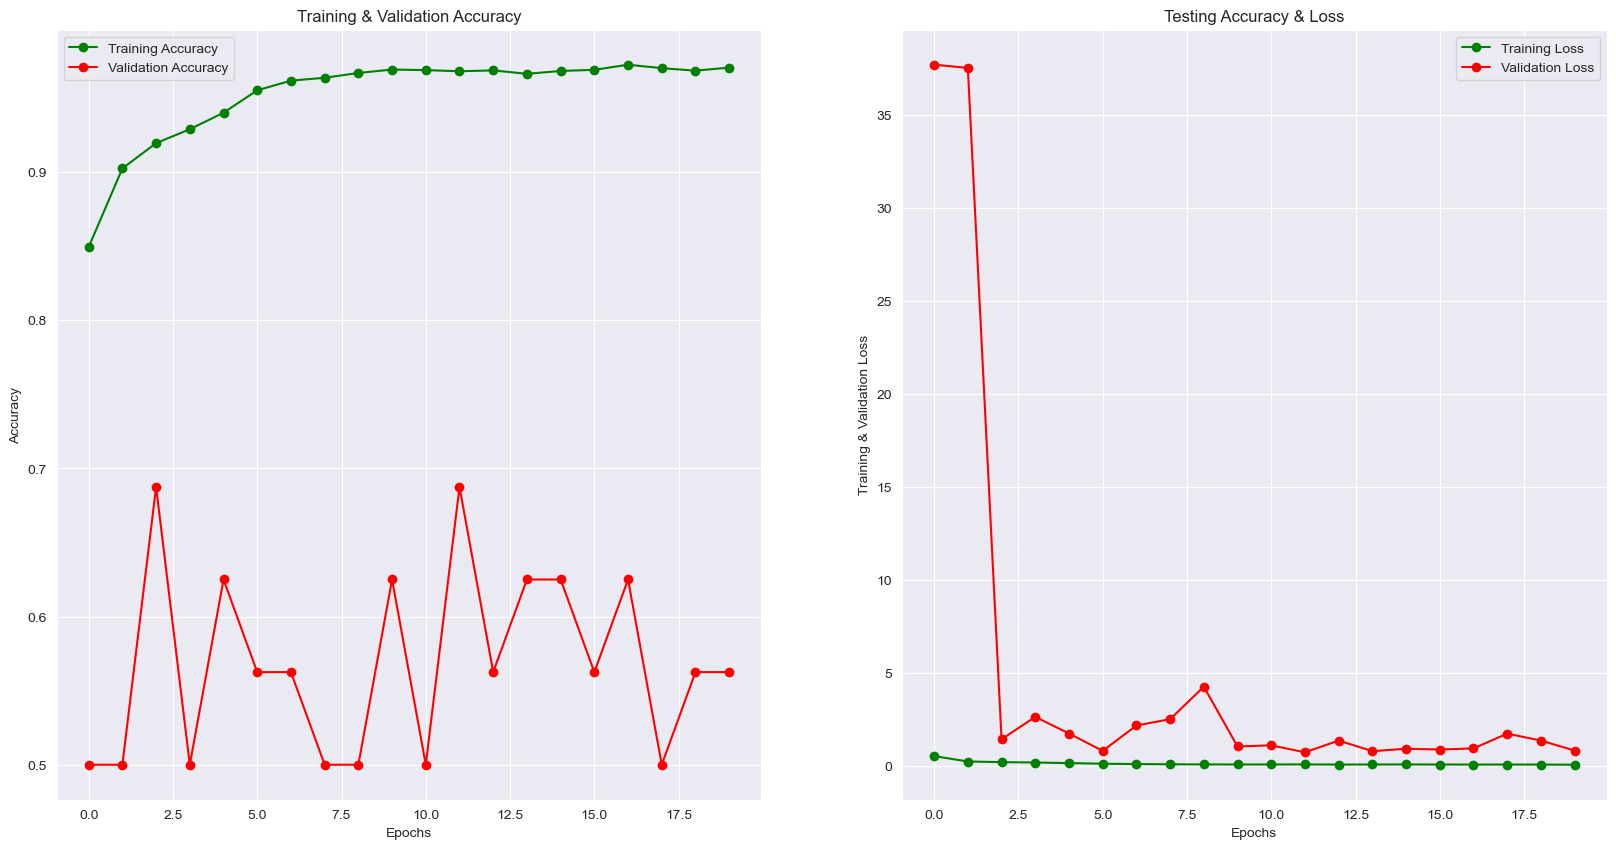

In [27]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [1]:
plt.figure(figsize=[10,6])
plt.plot(history.history["accuracy"], label = "Train acc")
plt.plot(history.history["val_accuracy"], label = "Validation acc")
plt.legend()
plt.show()

NameError: name 'plt' is not defined

In [2]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label = "Train loss")
plt.plot(history.history['val_loss'], label = "Validation loss")
plt.legend()
plt.show()

NameError: name 'plt' is not defined

In [28]:
predictions = model.predict(x_test)

predicted_labels = (predictions > 0.5).astype(int)
predictions = predicted_labels.flatten().reshape(-1,1)
predictions[530:540]

20/20 [==============================] - 3s 150ms/step


array([[0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1]])

In [29]:
# Converting into 1D array

predictions = np.squeeze(predictions)
predictions[530:540]

array([0, 0, 1, 0, 0, 1, 0, 1, 1, 1])

In [30]:
predictions.size

624

In [31]:
count_0 = 0
count_1 = 0

for ele in predictions:
    if ele == 0:
        count_0 += 1
    elif ele == 1:
        count_1 += 1

print("Predictions:\nNumber of Pneumonia samples '0' = ", count_0)
print("Number of Normal samples'1' = ", count_1)

Predictions:
Number of Pneumonia samples '0' =  412
Number of Normal(1) samples'1' =  212


In [32]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.91      0.96      0.94       390
   Normal (Class 1)       0.93      0.85      0.89       234

           accuracy                           0.92       624
          macro avg       0.92      0.91      0.91       624
       weighted avg       0.92      0.92      0.92       624



# 6. Confusion Matrix

In [33]:
cm = confusion_matrix(y_test,predictions)
cm

array([[376,  14],
       [ 36, 198]], dtype=int64)

In [34]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

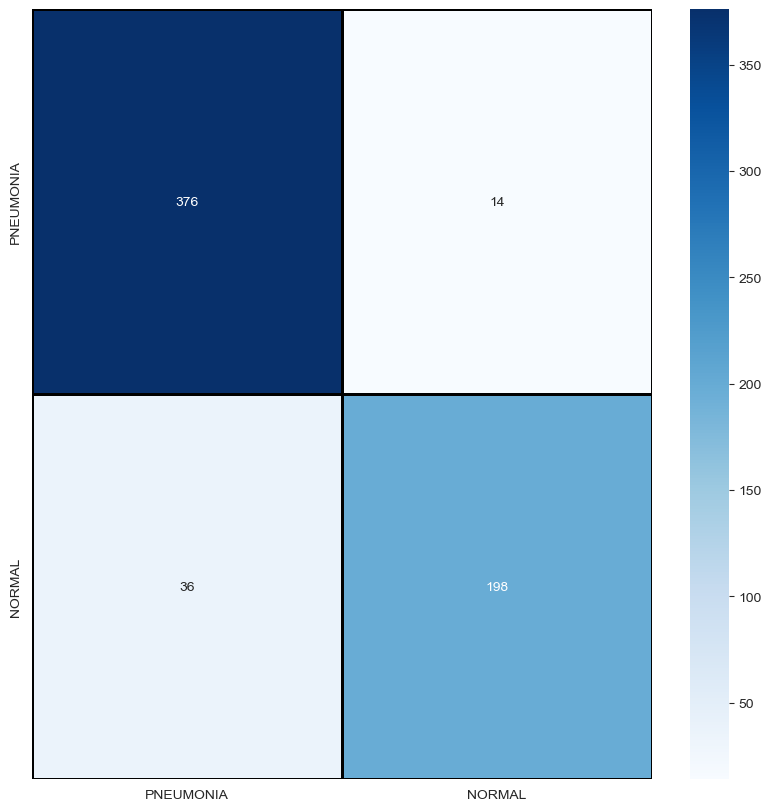

In [36]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)
plt.show()

# 7. Visualizing the predicted images

In [37]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

In [38]:
correct

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  49,  50,  51,  52,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
        81,  82,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
        95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 109, 110, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
       135, 136, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
       149, 150, 151, 152, 153, 155, 158, 159, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 18

In [39]:
correct.size

574

In [40]:
incorrect

array([ 48,  53,  54,  83, 111, 137, 154, 156, 157, 239, 242, 245, 365,
       367, 406, 451, 479, 503, 509, 510, 511, 512, 513, 514, 516, 518,
       519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531,
       533, 534, 536, 550, 556, 561, 571, 583, 590, 606, 616], dtype=int64)

In [41]:
incorrect.size

50

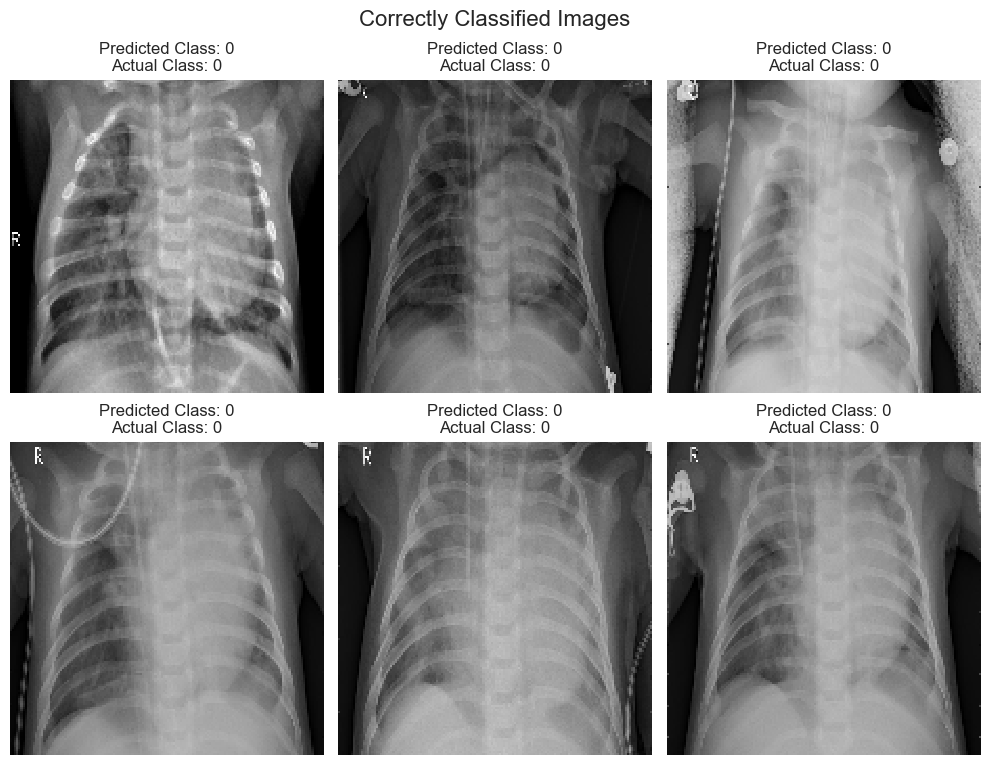

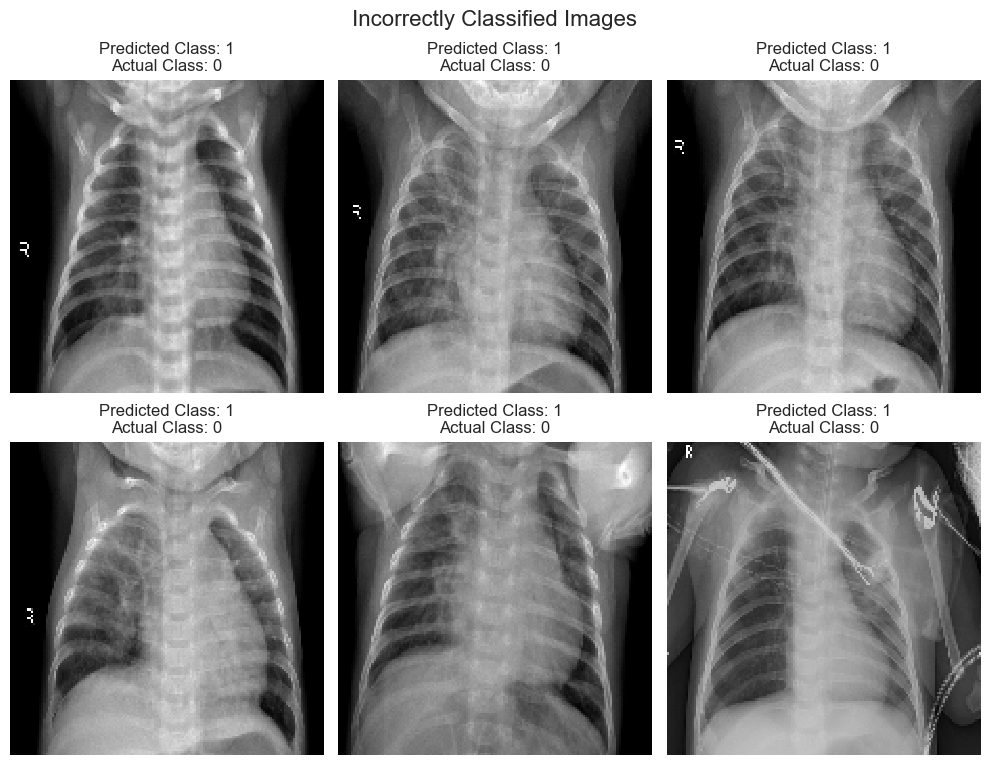

In [44]:
# Visualize correctly classified images
fig, axes = plt.subplots(2, 3, figsize=(10, 8))
fig.suptitle('Correctly Classified Images', fontsize=16)

for i, idx in enumerate(correct[:6]):
    row = i // 3
    col = i % 3
    axes[row, col].imshow(x_test[idx].reshape(150, 150), cmap="gray", interpolation='none')
    axes[row, col].set_title("Predicted Class: {}\nActual Class: {}".format(predictions[idx], y_test[idx]))
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# Visualize incorrectly classified images
fig, axes = plt.subplots(2, 3, figsize=(10, 8))
fig.suptitle('Incorrectly Classified Images', fontsize=16)

for i, idx in enumerate(incorrect[:6]):
    row = i // 3
    col = i % 3
    axes[row, col].imshow(x_test[idx].reshape(150, 150), cmap="gray", interpolation='none')
    axes[row, col].set_title("Predicted Class: {}\nActual Class: {}".format(predictions[idx], y_test[idx]))
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

C:\Users\ACER\AppData\Local\Temp\ipykernel_17832\4179179071.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)


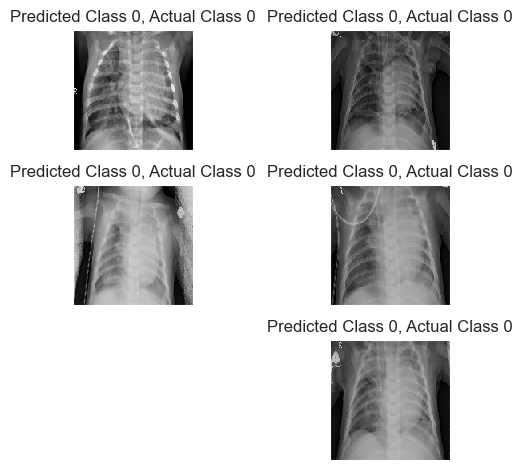

In [42]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {}, Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

C:\Users\ACER\AppData\Local\Temp\ipykernel_17832\2342926093.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)


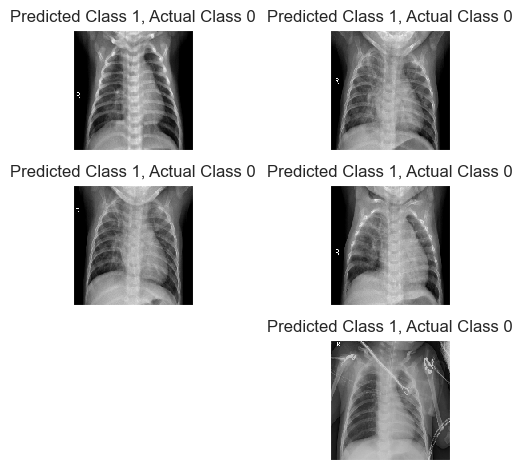

In [43]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {}, Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

# Random Prediction

In [46]:
image = "C:\\Users\ACER\\Desktop\\Jupyter\\Project v1 (2 Classes) [Complete]\\v1 Dataset\\chest_xray\\test\\NORMAL\\NORMAL2-IM-0309-0001.jpeg"

def preprocess_image(image_path):
    img_arr = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    resized_arr = cv2.resize(img_arr, (img_size, img_size))
    preprocessed_img = np.array(resized_arr) / 255.0
    preprocessed_img = preprocessed_img.reshape(-1, img_size, img_size, 1)
    return preprocessed_img

# Assuming 'image' is the variable containing the path to the image you want to predict
preprocessed_img = preprocess_image(image)
prediction = model.predict(preprocessed_img)
predicted_class = labels[int(np.round(prediction))]
print("Predicted class:", predicted_class)

1/1 [==============================] - 0s 17ms/step
Predicted class: NORMAL
